In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math
import param

#need to test some of the movements here- model it after what Borna does, with the defined parameters that are then
#used to change the step size

# unit cell parameters in A- this is for the TiO2 (110) suraface. Will neet to change to multiples of the PES.
#not sure why this is included in the simulation. 
unitcell_a = 13.216
unitcell_b = 12.243
unitcell_c = 26.362

# primitive cell parameters in A (used for PES)
primcell_a = 4.84025 #these are the lengths of the a and b vectors- not the coordinates of then in cartesian
primcell_b = 4.84025 #would it be a good idea to add in the angle between the unit cells as well, and make that
                     #something used to walk around on the mesh?
N_mesh = 11*11
meshx = 0.1 #added from Borna's PES code
meshy = 0.1 #added from Borna's PES code
xstep_max  =  primcell_a / 10.0
ystep_max  =  primcell_b / 10.0

Xstep = primcell_a - primcell_b*np.cos(np.deg2rad(60))
Ystep = primcell_b*np.sin(np.deg2rad(60))
#okay, so what's basically happening above here is that it's defining the step_max to be a 10th of the primitive cell
#so what I think I need to do is for the PES_finder for the step, and any cases where a step is being taken,
#add a sin or cos as necessary to make sure that the step is going in the right way, not just being added/subtracted
#from the square lattice that we think of. I think I can just use what he used for tmp_x and tmp_y for generating
#the mesh in the first place. I should play around with geometry first though, to make sure it's clear in my head. 

# x and y boundaries of simulation
maxx   =  primcell_a * 2
minx   =  0.0 #this needs to be defined differently - I think if i define the vector rel to (0,0) then scale the
              #vector appropriately- probably just define it in the cdes
maxy   =  primcell_b * np.sqrt(3)/2 * 2
miny   =  0.0


x=[]
y=[]
for i in np.arange(0,2.1,meshx):
        for j in np.arange(0,2.1,meshy):
            tmp_X = i*primcell_a - j*primcell_b*np.cos(np.deg2rad(60))
            tmp_Y = j*primcell_b*np.sin(np.deg2rad(60))
            x.append(tmp_X)
            y.append(tmp_Y)

            
def X_finder(y_coord,primcell,maxx): #this won't work for a supercell- have to play around with it! maybe do all rel maxx?
    #gives the minimum and maximum x values for a given y coordinate
    frac= y_coord /  (primcell * (np.sqrt(3)/2))
    min_x = frac * primcell * (-0.5)
    max_x = min_x + maxx
    return min_x, max_x


In [7]:
def PES_finder(X_new, Y_new, PES_copy, N_mesh):
    finder = False
    n = 0
    
    print(str(X_new) + "    "+ str(Y_new))
    
    for ii in range(N_mesh - 1):
        #print("count" + str(n))
        #n = n + 1
        # old code
        #dx =  np.abs( param.xstep_max*( math.ceil(X_new/param.xstep_max) % N_meshx ) - PES_copy[ii][1] )
        #dy =  np.abs( param.ystep_max*( math.ceil(Y_new/param.ystep_max) % N_meshy ) - PES_copy[ii][2] )
        dy =  np.abs(  Y_new % (param.primcell_b *  np.sqrt(3)/2)- PES_copy[ii][2] )
        yShiftForX = Y_new - ( Y_new % (param.primcell_b *  np.sqrt(3)/2))
        dx =  np.abs( ((X_new +  yShiftForX *  1 /2)% param.primcell_a) - PES_copy[ii][1] )
        #print(( Y_new % (param.primcell_b *  np.sqrt(3)/2)))
        #print(str(dx) + ' ' + str(dy))
        
        
        if ( dx  < 0.1 and dy  < 0.1 ):    
            # PES found 
            print("find!")
            E_PES  = PES_copy[ii][3] 
            finder = True
            break    
    if (finder == False):
        raise ValueError('Could not find PES for single atom. Bad move! Check you initial setup')      
    return E_PES



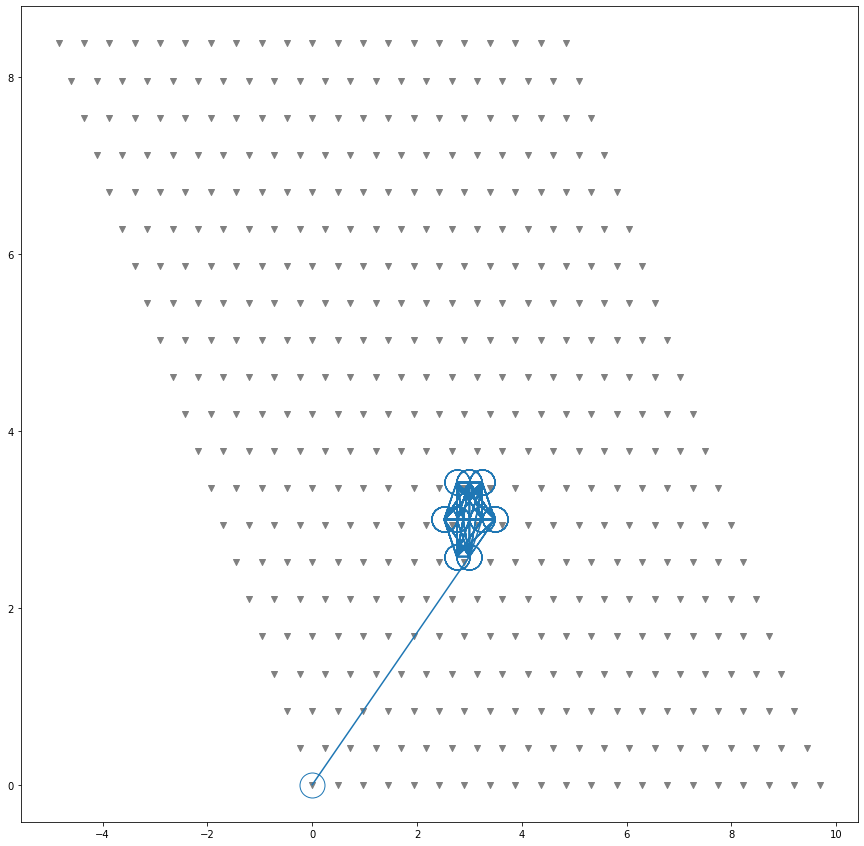

In [32]:
#final walking around, with the PBC working (for the primcell- need to think about expanding to a supercell)
#this is all steps of just a single mesh step - I should probably make sure that it works for larger jumps. 
start=np.random.randint(0,len(x))
traj=[[x[0],y[0]]]
#direction_choice=[[1,0],[1/2,np.sqrt(3)/2],[-1/2,np.sqrt(3)/2],[-1/2,-np.sqrt(3)/2],[-1,0],[1/2,np.sqrt(3)/2]]
choose_dir    = [[1,0],[1/2,np.sqrt(3)/2],[-1/2,np.sqrt(3)/2],[-1/2,-np.sqrt(3)/2],[-1,0],[1/2,np.sqrt(3)/2]]
#step_size=np.random.randint(-3,3)
steps=[]

R_temp = 0.4

X_temp = Y_temp = 3

for i in range(1,300):
     #this is where the new X and Y coords are generated- this is probably where to add the scaling vectors. 
    direction_choice = choose_dir[np.random.randint(0,len(choose_dir))] #this is choosing the direction

    px = math.ceil( ( 2.0*R_temp)  * ( 2.0*np.random.rand() - 1.0 ) ) # the step-size is cluster size dependent
    py = math.ceil( ( 2.0*R_temp)  * ( 2.0*np.random.rand() - 1.0 ) ) 
    
    X_new = X_temp + direction_choice[0] *px * param.xstep_max #choosing the direction of the step
    Y_new = Y_temp + direction_choice[1] *py * param.ystep_max

    x_find = X_finder(Y_new, param.primcell_a, param.maxx)       #to make the PBC easier (I think) 

    if ( X_new == X_temp and Y_new == Y_temp ): #no change
        continue
            
        # Periodic Boundry Conditions - edited for Al2O3 lattice 
        #do Y PBC first
    if ( Y_new > param.maxy ):
        Y_new = param.miny - param.maxy + Y_new
        X_new = (X_new-x_find[0]) + X_finder(Y_new,param.primcell_a,param.maxx)[0]
    elif ( Y_new < param.miny ):
        Y_new = param.maxy - param.miny + Y_new
        X_new = (X_new-x_find[0]) + X_finder(Y_new,param.primcell_a,param.maxx)[0]
        #then X PBC
    if ( X_new > param.maxx ):   
        X_new = X_finder(Y_new,param.primcell_a,param.maxx)[0] - X_finder(Y_new,param.primcell_a,param.maxx)[1] + X_new
    elif ( X_new < param.minx ):   
        X_new = X_finder(Y_new,param.primcell_a,param.maxx)[1] - X_finder(Y_new,param.primcell_a,param.maxx)[0] + X_new
            
    traj.append([X_new,Y_new])
    
    
    
trajx=[traj[i][0] for i in range(0,len(traj))]
trajy=[traj[i][1] for i in range(0,len(traj))]

#plot to check the walking around on the grid
plt.figure(figsize=(15,15))
plt.scatter(x,y,marker="v",color="gray")
plt.plot(trajx,trajy,marker="o",markerfacecolor="none",ms=25)
plt.show()